Author: Saman Paidar Nia

In [1]:
# Get important libraries for this class.
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import warnings
import csv
import random
import math
#-----------------------------------------------------------
from tensorflow.python.ops import control_flow_ops
from IPython.display import clear_output
from scipy.spatial.distance import squareform, pdist
from sklearn.preprocessing import normalize
from numpy import linalg as LA
from scipy.cluster.vq import kmeans, vq
from sklearn.metrics import normalized_mutual_info_score
from tqdm import tqdm
from math import sqrt
#------------------------------------------------------------
from sklearn.datasets import fetch_20newsgroups
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics
import logging
from optparse import OptionParser
import sys

In [2]:
class Similarity_func:
    def sigmoidal_normalize(self, X):
        return (X - min(X)) / (max(X) - min(X))

In [3]:
class Cosine_Similarity(Similarity_func):
    def get_matrix(self, X):
        X = normalize(X, axis=0)
        x = squareform(pdist(X, 'cosine'))
        x = np.dot(LA.matrix_power(np.diag(np.sum(x, 0)), -1), x)
        x = np.apply_along_axis(self.sigmoidal_normalize, 1, x)
        np.fill_diagonal(x, 0.)
        return x

In [4]:
class Similarity_Dataset_Iterator():
    def __init__(self, data, labels, similarity):
        self.data = data
        self.labels = labels
        self.matrix = similarity.get_matrix(data)
        self.data_size = self.matrix.shape[0]
        self.current_index = 0
    def next_batch(self, num):
        data=self.matrix.transpose()
        labels=self.labels
        idx = np.arange(0 , len(data))
        np.random.shuffle(idx)
        idx = idx[:num]
        data_shuffle = [data[ i] for i in idx]
        labels_shuffle = [labels[ i] for i in idx]
        return data_shuffle, labels_shuffle
    def whole_dataset(self):
        return (self.matrix.transpose(), self.labels)

In [5]:
#  Using Scikit-Learn libraries to fetching the Newsgroups data set: http://scikit-learn.org
def read_NewsGroup_data(similarity):
    logging.basicConfig(level=logging.INFO,
                        format='%(asctime)s %(levelname)s %(message)s')
    op = OptionParser()
    op.add_option("--lsa",
                  dest="n_components", type="int",
                  help="Preprocess documents with latent semantic analysis.")    
    op.add_option("--no-idf",action="store_false", dest="use_idf", default=True,
                  help="Disable Inverse Document Frequency feature weighting.")
    op.add_option("--use-hashing", action="store_true", default=False,
                  help="Use a hashing feature vectorizer")
    op.add_option("--n-features", type=int, default=10000,
                  help="Maximum number of features to extract from text.")    
    def is_interactive():
        return not hasattr(sys.modules['__main__'], '__file__')
    argv = [] if is_interactive() else sys.argv[1:]
    (opts, args) = op.parse_args(argv)
    if len(args) > 0:
        op.error("this script takes no arguments.")
        sys.exit(1)    
    categories_6NG = ['alt.atheism','comp.sys.mac.hardware','rec.motorcycles',
                      'rec.sport.hockey','soc.religion.christian','talk.religion.misc']
    # categories = categories_6NG
    dataset = fetch_20newsgroups(subset='all', categories=categories_6NG,
                                 shuffle=True, random_state=42)
    labels = dataset.target[:1200]
    true_k = np.unique(labels).shape[0]
    vectorizer = TfidfVectorizer(max_df=0.5, max_features=opts.n_features,min_df=2,
                                 stop_words='english',use_idf=opts.use_idf)
    X = vectorizer.fit_transform(dataset.data[:1200])
    if opts.n_components:
        svd = TruncatedSVD(opts.n_components)
        normalizer = Normalizer(copy=False)
        lsa = make_pipeline(svd, normalizer)
        X = lsa.fit_transform(X)
        explained_variance = svd.explained_variance_ratio_.sum()
    return Similarity_Dataset_Iterator(X.toarray(), labels, similarity)

In [6]:
# Call Cosine_Similarity as similarity dataset.
data_set_train = read_NewsGroup_data(Cosine_Similarity())

In [7]:
def k_means_(X, n_cluster):
    kmeans_centroids,_ =  kmeans(X,n_cluster)
    kmeans_, _ = vq(X, kmeans_centroids)
    return kmeans_

In [8]:
n_input = data_set_train.data_size #--------- Number of input data.
# Define the number of hidden layer. 
if n_input >= 1024:
    Nn = int(2048)
elif n_input >= 512:
    Nn = int(1024)
elif n_input >= 256:
    Nn = int(512)

In [9]:
n_hidden_1 = int(Nn/2) #-------------------- The autoencoder hidden layer 1.
n_hidden_2 = int(n_hidden_1/2) #------------ The autoencoder hidden layer 2.
n_hidden_3 = int(n_hidden_2/2) #------------ The autoencoder hidden layer 3.
n_code = str(int(n_hidden_3/2)) #----------- The number of output dimension value.

In [10]:
def encoder(x, n_code, phase_train):    
    with tf.variable_scope("encoder"):        
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(x, [n_input, n_hidden_1], [n_hidden_1], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_1, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_3], [n_hidden_3], phase_train)        
        with tf.variable_scope("code"):
            code = layer(hidden_3, [n_hidden_3, n_code], [n_code], phase_train)
    return code

In [11]:
def decoder(code, n_code, phase_train):
    with tf.variable_scope("decoder"):
        with tf.variable_scope("hidden_1"):
            hidden_1 = layer(code, [n_code, n_hidden_3], [n_hidden_3], phase_train)
        with tf.variable_scope("hidden_2"):
            hidden_2 = layer(hidden_1, [n_hidden_3, n_hidden_2], [n_hidden_2], phase_train)
        with tf.variable_scope("hidden_3"):
            hidden_3 = layer(hidden_2, [n_hidden_2, n_hidden_1], [n_hidden_1], phase_train)              
        with tf.variable_scope("output"):
            output = layer(hidden_3, [n_hidden_1, n_input], [n_input], phase_train)
    return output

In [12]:
def layer_batch_norm(x, n_out, phase_train):
    beta_init = tf.constant_initializer(value=0.0, dtype=tf.float32)
    gamma_init = tf.constant_initializer(value=1.0, dtype=tf.float32)
    beta = tf.get_variable("beta", [n_out], initializer=beta_init)
    gamma = tf.get_variable("gamma", [n_out], initializer=gamma_init)
    batch_mean, batch_var = tf.nn.moments(x, [0], name='moments')
    ema = tf.train.ExponentialMovingAverage(decay=0.9)
    ema_apply_op = ema.apply([batch_mean, batch_var])
    ema_mean, ema_var = ema.average(batch_mean), ema.average(batch_var)
    def mean_var_with_update():
        with tf.control_dependencies([ema_apply_op]):
            return tf.identity(batch_mean), tf.identity(batch_var)
    mean, var = control_flow_ops.cond(phase_train, mean_var_with_update, lambda: (ema_mean, ema_var))
    reshaped_x = tf.reshape(x, [-1, 1, 1, n_out])
    normed = tf.nn.batch_norm_with_global_normalization(reshaped_x, mean, var, beta, gamma, 1e-3, True)
    return tf.reshape(normed, [-1, n_out])

In [13]:
def layer(input, weight_shape, bias_shape, phase_train):
    weight_init = tf.random_normal_initializer(stddev=(1.0 / weight_shape[0]) ** 0.5)
    bias_init = tf.constant_initializer(value=0)
    W = tf.get_variable("W", weight_shape, initializer=weight_init)
    b = tf.get_variable("b", bias_shape, initializer=bias_init)
    logits = tf.matmul(input, W) + b
    return tf.nn.sigmoid(layer_batch_norm(logits, weight_shape[1], phase_train))

In [14]:
def loss(output, x):
    with tf.variable_scope("training"):
        train_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(output, x)), 1))
        return train_loss/10

In [15]:
def evaluate(output, x):
    with tf.variable_scope("validation"):
        val_loss = tf.reduce_mean(tf.reduce_sum(tf.square(tf.subtract(output, x, name="val_diff")), 1))
        return val_loss/10

In [16]:
def training(cost, learning_rate, beta1, beta2, global_step):
    optimizer = tf.train.AdamOptimizer(learning_rate, beta1, beta2, epsilon=1e-08, use_locking=False, name='Adam')
    train_op = optimizer.minimize(cost, global_step=global_step)
    return train_op

In [17]:
# Parameters
n_layers = 5 #----------------------------- Number of Neural Networks Layers.
beta1 = 0.9 #------------------------------ The decay rate 1.  
beta2 = 0.999 #---------------------------- The decay rate 2.
learning_rate = (beta1/n_input) #---------- The learning rate.
stop_learning = 0.13 #--------------------- The stop learning point.
n_batch = math.ceil(sqrt(sqrt(n_input))) #- Number of selection data in per step.
n_backpro = math.ceil(n_input/n_batch) #--- Number of Backpro in per epoc
n_cluster = 6 #---------------------------- Number of clusters.
n_diplay = 10 #---------------------------- Number of getting code and runnig the K-Means.
results=[] #------------------------------- A list to keep all NMI scores.
loss_cost=[] #----------------------------- A list to keep all training evaluations.
steps=[] #--------------------------------- A list to keep all steps.

In [18]:
with tf.Graph().as_default():    
    with tf.variable_scope("autoencoder_model"):                
        x = tf.placeholder("float", [None, n_input])   
        phase_train = tf.placeholder(tf.bool)
        code = encoder(x, int(n_code), phase_train)
        output = decoder(code, int(n_code), phase_train)
        cost = loss(output, x)
        global_step = tf.Variable(0, name='global_step', trainable=False)
        train_optimizer = training(cost, learning_rate, beta1, beta2, global_step)
        eval_optimizer = evaluate(output, x)
        summary_op = tf.summary.merge_all()
        sess = tf.Session()
        init_op = tf.global_variables_initializer()
        sess.run(init_op)

In [19]:
# Training cycle
epoch = 0
first_pass = True
while first_pass or new_cost > stop_learning:
    first_pass = False
    # Fit training with Backpropagation using batch data.
    for i in range(n_backpro):
        miniData, _ = data_set_train.next_batch(n_batch)
        _,new_cost = sess.run([train_optimizer, cost], feed_dict={x: miniData,
                                                                  phase_train: True})
       #---------------- End of the Backpropagation with Random Walk ----------------
    randomData, _ = data_set_train.next_batch(n_input)
    sess.run(eval_optimizer, feed_dict={x: randomData,
                                        phase_train: True})
    #------------------------- End of the Optimization ---------------------------
    epoch += 1
    # Save the results after per (Size of input / n_layers) epochs.    
    if epoch % n_diplay == 0 or new_cost <= stop_learning:
        # Getting embedded codes and running K-Means on them.
        ae_codes = sess.run(code, feed_dict={x: data_set_train.whole_dataset()[0],
                                         phase_train: False})        
        idx = k_means_(ae_codes, n_cluster)
        ae_nmi = normalized_mutual_info_score(data_set_train.whole_dataset()[1], idx)
        results.append(ae_nmi)    
        steps.append(epoch)
        loss_cost.append(new_cost)    
        print("NMI Score for AE is: {:0.2f} and new cost is: {:0.2f} in {:d} step. "
              .format(ae_nmi, new_cost, epoch))

NMI Score for AE is: 0.44 and new cost is: 5.89 in 10 step. 
NMI Score for AE is: 0.46 and new cost is: 1.67 in 20 step. 
NMI Score for AE is: 0.48 and new cost is: 0.62 in 30 step. 
NMI Score for AE is: 0.50 and new cost is: 0.29 in 40 step. 
NMI Score for AE is: 0.57 and new cost is: 0.20 in 50 step. 
NMI Score for AE is: 0.64 and new cost is: 0.15 in 60 step. 
NMI Score for AE is: 0.65 and new cost is: 0.13 in 63 step. 


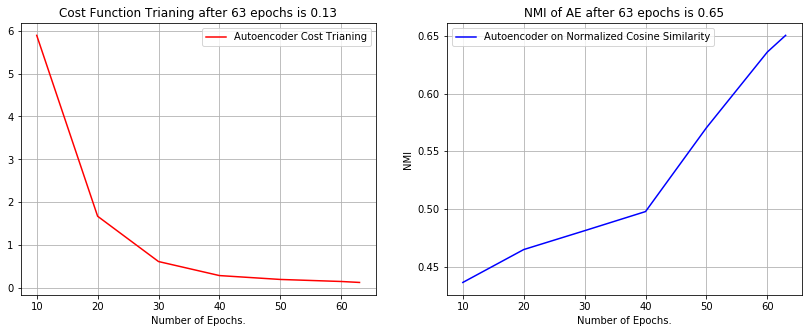

In [21]:
warnings.filterwarnings('ignore')
plt.figure(figsize=(14, 5))
plt.subplot(1,2,1)
plt.errorbar(steps, loss_cost, label='Autoencoder Cost Trianing', color='r')
plt.xlabel('Number of Epochs.')
plt.grid()
plt.title(('Cost Function Trianing after {:d} epochs is {:0.2f}').format(epoch, new_cost))
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.errorbar(steps, results, label='Autoencoder on Normalized Cosine Similarity', color='b')
plt.xlabel('Number of Epochs.')
plt.ylabel('NMI')
plt.grid()
plt.title(('NMI of AE after {:d} epochs is {:0.2f}').format(epoch, ae_nmi))
plt.legend(loc='best')
plt.show()